# Analysis of Different Machine Learning and Econometric Models to Predict Crypto Currencies High-Frequency Behaviour


#### Oğuzhan PINAR - 22.01.2022

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to see and hide the raw codes."></form>''')

# CODES
# 1. Data Collection

For this part of the case I will build a class named data_constructor which connects with the Binance API and gets data. This class will be the main tool to build data for modelling. Here are some important details of the data_constructor class:


    1. The API limits the data with 500 rows per request. To generate wider range we will send multiple reequests and merge the resulting dataframes.

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing.pool import ThreadPool

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))


class data_constructor():

    def __init__(self,  api_row_limit=500):
        self.endpoint_url = "https://api.binance.com"
        self.api_row_limit = api_row_limit

    def get_klines_data(self, symbol, interval, start_datetime, end_datetime):
        
        #This method calls methods and returns the whole required data (consider it like __main__ function)
    
        #Create required parameters:
        interval_td = self.interval_to_timedelta(interval) # Convert interval to timedelta object
        self.start_datetime = start_datetime
        self.start_timestamp = str(int(start_datetime.timestamp()*1000))
        self.end_datetime = end_datetime
        self.end_timestamp = str(int(end_datetime.timestamp()*1000))
        
        #Call the methods 
        temp_start_ends = self.create_start_end_dates(interval_td)
        merged_data = self.send_requests_and_merge_data(temp_start_ends, symbol, interval)
        return merged_data
        
        
    def get_partial_data(self, _temp_start_timestamp, _temp_end_timestamp, symbol, interval):
        
        # This method gets a part of data using Binance API
        
        klines_extension  = "/api/v3/klines"
        parameters = {'symbol': symbol, 'interval': interval, 'startTime': _temp_start_timestamp, 'endTime': _temp_end_timestamp}
        url = self.endpoint_url + klines_extension

        # Get the data from API and filter unnecessary columns:
        api_answer = json.loads(requests.get(url, params = parameters).text)
        df = pd.DataFrame(api_answer).iloc[:, 0:6]

        # Format the columns and index:
        df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
        df.index = df.timestamp.apply(lambda x: dt.datetime.fromtimestamp(x/1000.0)) # Convert timestamp to datetime object
        return df
    
    def create_start_end_dates(self, interval_td):
        
        # This method creates start and end dates considering the 500 rows API limit.
        
        # Calculate the timestamp difference for interval:
        _temp_dt =  self.start_datetime + interval_td
        interval_timestamp = int(_temp_dt.timestamp()*1000) - int(self.start_timestamp)
        
        #Get the starting and ending timestamps:
        starting_timestamps = np.array(range(int(self.start_timestamp), int(self.end_timestamp), interval_timestamp*self.api_row_limit))
        ending_timestamps   = starting_timestamps + interval_timestamp*(self.api_row_limit - 1)
        
        #Create a df with starts and ends:
        temp_start_ends = pd.DataFrame({"temp_starts": starting_timestamps, "temp_ends" : ending_timestamps})
        
        #Fix the last end timestamp:
        temp_start_ends.iloc[-1,-1] = self.end_timestamp
        
        return temp_start_ends
        
    def send_requests_and_merge_data(self, temp_start_ends, symbol, interval):
        
        #Send the requests: (For better performance use Threads TO BE DEVELOPED...)
        partial_klines = temp_start_ends.apply(lambda x: self.get_partial_data(x.temp_starts, x.temp_ends, symbol, interval), axis=1)
        # Merge the data:
        merged_data = pd.concat(list(partial_klines), axis=0)
        return merged_data
    
    def interval_to_timedelta(self, interval):
        
        # This method converts string interval object to a timedelta object.
        
        intervalLetter = interval[-1].lower()
        intervalNumber = int(interval[:-1])
        
        if (intervalLetter == "s"):
            interval_td = dt.timedelta(seconds = intervalNumber)
        elif (intervalLetter == "m"):
            interval_td = dt.timedelta(minutes = intervalNumber)
        elif (intervalLetter == "h"):
            interval_td = dt.timedelta(hours = intervalNumber)
        elif (intervalLetter == "d"):
            interval_td = dt.timedelta(days = intervalNumber)
        
        return interval_td
        


Now I will construct 1 minute klines data for each coin given in the list. For the duration from 1 November 2022 to 23 December 2022. Note that in order to prevent the impacts of possible different behaviour during Christmas on the models I will use dates before the Christmas. Also, To get the data faster, I will create a thread for each coin. 



In [3]:
begin_time = dt.datetime.now()

start = dt.datetime(2022,11,1)
end = dt.datetime(2022,12,23)

my_data_constructor = data_constructor()
coin_list = ["BTC", "ETH", "BNB", "DOGE", "ADA", "MATIC", "DOT", "TRX", "LTC", "SOL", "UNI", 
             "AVAX", "LINK", "XMR", "ATOM", "ETC", "XLM", "ALGO", "VET", "NEAR", "HBAR"]

klines_data_dict = {}
threads_dic = {}
pool = ThreadPool(processes=5)

#Start pooling:
for coin in coin_list:
    symbol = coin + "USDT"
    async_result = pool.apply_async(my_data_constructor.get_klines_data, args = (symbol, "1m", start, end))
    threads_dic[symbol] = async_result

    
#Get results:
for coin in coin_list:        
    symbol = coin + "USDT"
    returned_df = threads_dic[symbol].get()
    klines_data_dict[symbol] = returned_df
    
    
time_cost_pooling = dt.datetime.now() - begin_time

In [57]:
dt.datetime.fromtimestamp(1667250000)

datetime.datetime(2022, 11, 1, 0, 0)

In [56]:
st_ends

,temp_starts,temp_ends
0,1667250000000,1667279940000
1,1667280000000,1667309940000
2,1667310000000,1667339940000
3,1667340000000,1667369940000
4,1667370000000,1667399940000
...,...,...
145,1671600000000,1671629940000
146,1671630000000,1671659940000
147,1671660000000,1671689940000
148,1671690000000,1671719940000


In [63]:
st_ends

,temp_starts,temp_ends
0,2022-11-01 00:00:00,1667279940000
1,2022-11-01 08:20:00,1667309940000
2,2022-11-01 16:40:00,1667339940000
3,2022-11-02 01:00:00,1667369940000
4,2022-11-02 09:20:00,1667399940000
...,...,...
145,2022-12-21 08:20:00,1671629940000
146,2022-12-21 16:40:00,1671659940000
147,2022-12-22 01:00:00,1671689940000
148,2022-12-22 09:20:00,1671719940000


In [64]:
int_td = my_data_constructor.interval_to_timedelta("1m")
st_ends = my_data_constructor.create_start_end_dates(int_td)

st_ends.temp_starts = st_ends.temp_starts.apply(lambda x: dt.datetime.fromtimestamp(x/1000), 1)
st_ends.temp_ends = st_ends.temp_ends.apply(lambda x: dt.datetime.fromtimestamp(int(x)/1000), 1)

In [65]:
my_data_constructor.create_start_end_dates("1m")

,temp_starts,temp_ends
0,2022-11-01 00:00:00,2022-11-01 08:19:00
1,2022-11-01 08:20:00,2022-11-01 16:39:00
2,2022-11-01 16:40:00,2022-11-02 00:59:00
3,2022-11-02 01:00:00,2022-11-02 09:19:00
4,2022-11-02 09:20:00,2022-11-02 17:39:00
...,...,...
145,2022-12-21 08:20:00,2022-12-21 16:39:00
146,2022-12-21 16:40:00,2022-12-22 00:59:00
147,2022-12-22 01:00:00,2022-12-22 09:19:00
148,2022-12-22 09:20:00,2022-12-22 17:39:00


In [4]:
time_cost_pooling

datetime.timedelta(seconds=352, microseconds=655461)

In [5]:
klines_data_dict

{'BTCUSDT':                          timestamp            open            high  \
 timestamp                                                            
 2022-11-01 00:00:00  1667250000000  20401.49000000  20404.67000000   
 2022-11-01 00:01:00  1667250060000  20404.62000000  20410.92000000   
 2022-11-01 00:02:00  1667250120000  20407.85000000  20410.90000000   
 2022-11-01 00:03:00  1667250180000  20408.44000000  20411.44000000   
 2022-11-01 00:04:00  1667250240000  20408.71000000  20414.99000000   
 ...                            ...             ...             ...   
 2022-12-22 23:56:00  1671742560000  16778.61000000  16786.87000000   
 2022-12-22 23:57:00  1671742620000  16785.43000000  16788.99000000   
 2022-12-22 23:58:00  1671742680000  16784.69000000  16789.42000000   
 2022-12-22 23:59:00  1671742740000  16782.91000000  16786.48000000   
 2022-12-23 00:00:00  1671742800000  16780.24000000  16795.41000000   
 
                                 low           close        volu

In [6]:
klines_data_dict.keys()

dict_keys(['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'DOGEUSDT', 'ADAUSDT', 'MATICUSDT', 'DOTUSDT', 'TRXUSDT', 'LTCUSDT', 'SOLUSDT', 'UNIUSDT', 'AVAXUSDT', 'LINKUSDT', 'XMRUSDT', 'ATOMUSDT', 'ETCUSDT', 'XLMUSDT', 'ALGOUSDT', 'VETUSDT', 'NEARUSDT', 'HBARUSDT'])

In [7]:
klines_data_dict["BTCUSDT"]

,timestamp,open,high,low,close,volume
timestamp,,,,,,
2022-11-01 00:00:00,1667250000000,20401.49000000,20404.67000000,20395.13000000,20403.51000000,199.00681000
2022-11-01 00:01:00,1667250060000,20404.62000000,20410.92000000,20399.73000000,20407.85000000,132.22353000
2022-11-01 00:02:00,1667250120000,20407.85000000,20410.90000000,20400.00000000,20408.44000000,62.67916000
2022-11-01 00:03:00,1667250180000,20408.44000000,20411.44000000,20406.18000000,20408.71000000,38.52220000
2022-11-01 00:04:00,1667250240000,20408.71000000,20414.99000000,20406.50000000,20413.75000000,47.37171000
...,...,...,...,...,...,...
2022-12-22 23:56:00,1671742560000,16778.61000000,16786.87000000,16772.03000000,16785.43000000,160.45849000
2022-12-22 23:57:00,1671742620000,16785.43000000,16788.99000000,16781.80000000,16784.69000000,95.95904000
2022-12-22 23:58:00,1671742680000,16784.69000000,16789.42000000,16781.31000000,16782.91000000,151.90584000


# 2. Label Detection:

In [8]:
def label_detector(df):
    return (df.close >= df.open)*1
    
for key in klines_data_dict:
    klines_data_dict[key]["label"] = label_detector(klines_data_dict[key])
    

In [9]:
klines_data_dict["BTCUSDT"]

,timestamp,open,high,low,close,volume,label
timestamp,,,,,,,
2022-11-01 00:00:00,1667250000000,20401.49000000,20404.67000000,20395.13000000,20403.51000000,199.00681000,1
2022-11-01 00:01:00,1667250060000,20404.62000000,20410.92000000,20399.73000000,20407.85000000,132.22353000,1
2022-11-01 00:02:00,1667250120000,20407.85000000,20410.90000000,20400.00000000,20408.44000000,62.67916000,1
2022-11-01 00:03:00,1667250180000,20408.44000000,20411.44000000,20406.18000000,20408.71000000,38.52220000,1
2022-11-01 00:04:00,1667250240000,20408.71000000,20414.99000000,20406.50000000,20413.75000000,47.37171000,1
...,...,...,...,...,...,...,...
2022-12-22 23:56:00,1671742560000,16778.61000000,16786.87000000,16772.03000000,16785.43000000,160.45849000,1
2022-12-22 23:57:00,1671742620000,16785.43000000,16788.99000000,16781.80000000,16784.69000000,95.95904000,0
2022-12-22 23:58:00,1671742680000,16784.69000000,16789.42000000,16781.31000000,16782.91000000,151.90584000,0


# 3. Feature Extraction

Important things:

    1. Lagging

Features to be included:
    
    1. Price_level(open) - profit - volume - range
    2. The labels and profit of 5 min - 15 min - 1 hour - 12 hours - 1 day candlesticks
    3. Other currencies weighted labels (weight with volume)
    4. (high - low) value ie range
    5. (open - close) value
    6. Weekend - weekday dummies
    7. Hour dummies
    8. Trend 
    

## 3.1. Class for extracting features

In this part, I will develop a class that prepares all features. The lagged variables and data leakage from future will not be considered in this part. Since, I will handle them later.

In [31]:
class extract_features():
    def __init__(self, symbol, data_dict):
        self.symbol = symbol
        self.data_dict = data_dict
        self.data_constructor = data_constructor()
        
    def get_not_lagged_features(self):
        
        all_features = self.get_price_level_profit_volume_range()
        all_features["market_weighted_label"] = self.get_weighted_market_labels()
        
        #Add larger time frame info:
        all_features = pd.concat([all_features, self.get_larger_timeframe_info("5m")], axis = 1)
        all_features = pd.concat([all_features, self.get_larger_timeframe_info("15m")], axis = 1)
        all_features = pd.concat([all_features, self.get_larger_timeframe_info("1h")], axis = 1)
        all_features = pd.concat([all_features, self.get_larger_timeframe_info("12h")], axis = 1)
        all_features = pd.concat([all_features, self.get_larger_timeframe_info("1d")], axis = 1)
       
        all_features = pd.concat([all_features, self.get_time_dummies()], axis = 1)
        
        all_features = all_features.dropna()
        all_features["trend"] = range(len(all_features))
        return all_features
    
    
    def get_price_level_profit_volume_range(self):
        symbol_data = self.data_dict[self.symbol].astype(float).copy(deep = False)
        price_profit_volume = pd.DataFrame()
        price_profit_volume["label"] = symbol_data.label
        price_profit_volume["price_level"] = symbol_data.open
        price_profit_volume["profit"] = (symbol_data["close"] - symbol_data["open"])/symbol_data["open"]
        price_profit_volume["volume"] = symbol_data.volume
        price_profit_volume["range"] = symbol_data.high - symbol_data.low
        return price_profit_volume
    
        
    def get_larger_timeframe_info(self, interval):
        
        # Get the larger timeframe klines data:
        start_dt = self.data_dict[self.symbol].index[0].to_pydatetime()
        end_dt = self.data_dict[self.symbol].index[-1].to_pydatetime()
        larger_tf_data = self.data_constructor.get_klines_data(self.symbol, interval, start_dt, end_dt )
        
        # Merge larger_tf_data and previous data we had and forward fill:
        # I will use open info from larger_tf_data but close from actual data in order not to leak future info.
        symbol_data = self.data_dict[self.symbol].copy(deep = False)
        symbol_data[interval + "_open"] = larger_tf_data.open
        symbol_data = symbol_data.fillna(method="ffill", axis=0)
        symbol_data = symbol_data.astype(float)
        
        #Calculate the profit and label for larger time frame
        symbol_data[interval + "_profit"] = (symbol_data.close - symbol_data[interval + "_open"])/symbol_data[interval + "_open"]
        symbol_data[interval + "_label"] = (symbol_data.close > symbol_data[interval + "_open"])*1
        larger_tf_profit_and_label = symbol_data.loc[:, [interval + "_profit" , interval + "_label"]]
        return larger_tf_profit_and_label
        
    
    def get_weighted_market_labels(self):
        total_volume = 0
        weighted_market_labels = 0
        
        for df in self.data_dict.values():
            total_volume += df.volume.astype(float)
            weighted_market_labels += df.volume.astype(float)*df.label
            
        weighted_market_labels = weighted_market_labels/total_volume
        return weighted_market_labels
    
    def get_time_dummies(self):
        symbol_data = self.data_dict[self.symbol].copy(deep = False)
        result_df = pd.get_dummies(np.round(symbol_data.index.hour/5).astype(int), prefix="day_part")
        result_df["is_weekday"] = (symbol_data.index.weekday <= 5)*1
        result_df.index = symbol_data.index
        return result_df

my_feature_extractor = extract_features("BTCUSDT", klines_data_dict)
all_features = my_feature_extractor.get_not_lagged_features()
all_features

,label,price_level,profit,volume,range,market_weighted_label,5m_profit,5m_label,15m_profit,15m_label,...,1d_profit,1d_label,day_part_0,day_part_1,day_part_2,day_part_3,day_part_4,day_part_5,is_weekday,trend
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-11-01 03:00:00,0.0,20490.74,-0.000739,355.07194,26.61,0.006240,-0.000739,0,-0.000739,0,...,-0.000739,0,0,1,0,0,0,0,1,0
2022-11-01 03:01:00,0.0,20474.28,-0.000156,241.41379,14.67,0.022875,-0.000959,0,-0.000959,0,...,-0.000959,0,0,1,0,0,0,0,1,1
2022-11-01 03:02:00,0.0,20471.08,-0.000217,409.49444,15.57,0.999550,-0.001177,0,-0.001177,0,...,-0.001177,0,0,1,0,0,0,0,1,2
2022-11-01 03:03:00,1.0,20467.36,0.000299,347.06217,24.30,0.869419,-0.000843,0,-0.000843,0,...,-0.000843,0,0,1,0,0,0,0,1,3
2022-11-01 03:04:00,1.0,20473.47,0.000162,214.82770,15.30,0.236484,-0.000681,0,-0.000681,0,...,-0.000681,0,0,1,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22 23:56:00,1.0,16778.61,0.000406,160.45849,14.84,1.000000,0.000080,1,0.001517,1,...,-0.002333,0,0,0,0,0,0,1,1,74696
2022-12-22 23:57:00,0.0,16785.43,-0.000044,95.95904,7.19,0.987086,0.000036,1,0.001473,1,...,-0.002377,0,0,0,0,0,0,1,1,74697
2022-12-22 23:58:00,0.0,16784.69,-0.000106,151.90584,8.11,0.964677,-0.000070,0,0.001366,1,...,-0.002483,0,0,0,0,0,0,1,1,74698


## 3.2. Lagged Values and Future Data Leakage Prevention:

In [32]:
all_features.columns

Index(['label', 'price_level', 'profit', 'volume', 'range',
       'market_weighted_label', '5m_profit', '5m_label', '15m_profit',
       '15m_label', '1h_profit', '1h_label', '12h_profit', '12h_label',
       '1d_profit', '1d_label', 'day_part_0', 'day_part_1', 'day_part_2',
       'day_part_3', 'day_part_4', 'day_part_5', 'is_weekday', 'trend'],
      dtype='object')

In [33]:
class create_lagged_features(extract_features):
    
    def __init__(self, symbol, data_dict):
        super(create_lagged_features, self).__init__(symbol, data_dict)
        
    def get_all_features(self):
        all_features = self.get_not_lagged_features()
        all_features = self.include_lags(all_features)
        all_features = self.drop_leaked_data(all_features)
        return all_features
    
    
    def include_lags(self, not_lagged_features):
        not_lagged_features["label_L1"]  = not_lagged_features.label.shift(1)
        not_lagged_features["label_L2"]  = not_lagged_features.label.shift(2)
        not_lagged_features["label_L3"]  = not_lagged_features.label.shift(3)
        not_lagged_features["label_L4"]  = not_lagged_features.label.shift(4)
        not_lagged_features["label_L5"]  = not_lagged_features.label.shift(5)
        
        not_lagged_features["profit_L1"] = not_lagged_features.profit.shift(1)
        not_lagged_features["profit_L2"] = not_lagged_features.profit.shift(2)
        not_lagged_features["profit_L3"] = not_lagged_features.profit.shift(3)
        not_lagged_features["profit_L4"] = not_lagged_features.profit.shift(4)
        not_lagged_features["profit_L5"] = not_lagged_features.profit.shift(5)
        
        not_lagged_features["volume_L1"] = not_lagged_features.volume.shift(1)
        not_lagged_features["volume_L2"] = not_lagged_features.volume.shift(2)
        not_lagged_features["volume_L3"] = not_lagged_features.volume.shift(3)
        not_lagged_features["volume_L4"] = not_lagged_features.volume.shift(4)
        not_lagged_features["volume_L5"] = not_lagged_features.volume.shift(5)
        
        not_lagged_features["range_L1"]  = not_lagged_features.range.shift(1)
        not_lagged_features["range_L2"]  = not_lagged_features.range.shift(2)
        not_lagged_features["range_L3"]  = not_lagged_features.range.shift(3)
        not_lagged_features["range_L4"]  = not_lagged_features.range.shift(4)
        not_lagged_features["range_L5"]  = not_lagged_features.range.shift(5)
        
        not_lagged_features["market_weighted_label_L1"] = not_lagged_features.market_weighted_label.shift(1)
        not_lagged_features["market_weighted_label_L2"] = not_lagged_features.market_weighted_label.shift(2)
        not_lagged_features["market_weighted_label_L3"] = not_lagged_features.market_weighted_label.shift(3)
        not_lagged_features["market_weighted_label_L4"] = not_lagged_features.market_weighted_label.shift(4)
        not_lagged_features["market_weighted_label_L5"] = not_lagged_features.market_weighted_label.shift(5)

        lagged_features = not_lagged_features.dropna()
        
        return lagged_features

    def drop_leaked_data(self, df):
        df = df.drop(["profit", "volume", "range", "market_weighted_label"], 1)
        return df 
    
my_feature_extractor = create_lagged_features("BTCUSDT", klines_data_dict)
all_features = my_feature_extractor.get_all_features()
all_features

,label,price_level,5m_profit,5m_label,15m_profit,15m_label,1h_profit,1h_label,12h_profit,12h_label,...,range_L1,range_L2,range_L3,range_L4,range_L5,market_weighted_label_L1,market_weighted_label_L2,market_weighted_label_L3,market_weighted_label_L4,market_weighted_label_L5
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-11-01 03:05:00,0.0,20477.72,-0.000816,0,-0.001451,0,-0.001451,0,-0.001451,0,...,15.30,24.30,15.57,14.67,26.61,0.236484,0.869419,0.999550,0.022875,0.006240
2022-11-01 03:06:00,0.0,20462.43,-0.000773,0,-0.001407,0,-0.001407,0,-0.001407,0,...,23.34,15.30,24.30,15.57,14.67,0.001050,0.236484,0.869419,0.999550,0.022875
2022-11-01 03:07:00,0.0,20461.90,-0.001046,0,-0.001681,0,-0.001681,0,-0.001681,0,...,13.16,23.34,15.30,24.30,15.57,0.061733,0.001050,0.236484,0.869419,0.999550
2022-11-01 03:08:00,1.0,20457.19,-0.000546,0,-0.001182,0,-0.001182,0,-0.001182,0,...,13.42,13.16,23.34,15.30,24.30,0.022187,0.061733,0.001050,0.236484,0.869419
2022-11-01 03:09:00,1.0,20465.41,-0.000458,0,-0.001093,0,-0.001093,0,-0.001093,0,...,15.32,13.42,13.16,23.34,15.30,1.000000,0.022187,0.061733,0.001050,0.236484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22 23:56:00,1.0,16778.61,0.000080,1,0.001517,1,0.007364,1,-0.002897,0,...,8.08,9.49,6.91,11.47,19.05,0.074770,0.140259,0.067415,0.997765,0.000259
2022-12-22 23:57:00,0.0,16785.43,0.000036,1,0.001473,1,0.007320,1,-0.002941,0,...,14.84,8.08,9.49,6.91,11.47,1.000000,0.074770,0.140259,0.067415,0.997765
2022-12-22 23:58:00,0.0,16784.69,-0.000070,0,0.001366,1,0.007213,1,-0.003047,0,...,7.19,14.84,8.08,9.49,6.91,0.987086,1.000000,0.074770,0.140259,0.067415


## 3.3. Apply feature creation to all coins:

In [34]:
features_dic = {}
feature_threads_dic = {}
pool = ThreadPool(processes=5)

my_feature_extractor = create_lagged_features("BTCUSDT", klines_data_dict)
all_features = my_feature_extractor.get_all_features()
all_features

#Start pooling:
for symbol in klines_data_dict.keys():
    temp_feat_ext = create_lagged_features(symbol, klines_data_dict)
    async_result = pool.apply_async(temp_feat_ext.get_all_features)
    feature_threads_dic[symbol] = async_result

    
#Get results:
for symbol in klines_data_dict.keys():    
    returned_df = feature_threads_dic[symbol].get()
    features_dic[symbol] = returned_df

In [35]:
features_dic.keys()

dict_keys(['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'DOGEUSDT', 'ADAUSDT', 'MATICUSDT', 'DOTUSDT', 'TRXUSDT', 'LTCUSDT', 'SOLUSDT', 'UNIUSDT', 'AVAXUSDT', 'LINKUSDT', 'XMRUSDT', 'ATOMUSDT', 'ETCUSDT', 'XLMUSDT', 'ALGOUSDT', 'VETUSDT', 'NEARUSDT', 'HBARUSDT'])

# 4. Modelling

## 4.1. Check Data:

In [36]:
features_dic["BTCUSDT"].describe().T

,count,mean,std,min,25%,50%,75%,max
label,74696.0,0.498019,0.499999,0.000000,0.000000,0.000000e+00,1.000000,1.000000
price_level,74696.0,17417.495489,1430.464288,15513.840000,16631.197500,1.688250e+04,17246.982500,21467.330000
5m_profit,74696.0,-0.000010,0.001444,-0.031146,-0.000365,-7.839195e-07,0.000368,0.055764
5m_label,74696.0,0.498996,0.500002,0.000000,0.000000,0.000000e+00,1.000000,1.000000
15m_profit,74696.0,-0.000028,0.002259,-0.041593,-0.000597,3.620487e-06,0.000590,0.055764
15m_label,74696.0,0.501660,0.500001,0.000000,0.000000,1.000000e+00,1.000000,1.000000
1h_profit,74696.0,-0.000155,0.004170,-0.077015,-0.001106,-2.907347e-05,0.000982,0.063691
1h_label,74696.0,0.490776,0.499918,0.000000,0.000000,0.000000e+00,1.000000,1.000000
12h_profit,74696.0,-0.000555,0.015118,-0.128485,-0.004988,-6.526919e-04,0.003448,0.104241
12h_label,74696.0,0.448257,0.497319,0.000000,0.000000,0.000000e+00,1.000000,1.000000


<AxesSubplot:ylabel='label'>

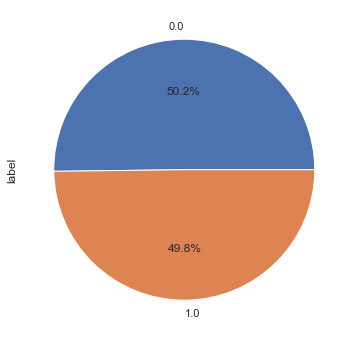

In [37]:
plt.figure(figsize=(6,6))
features_dic["BTCUSDT"]["label"].value_counts().plot.pie(autopct='%1.1f%%')


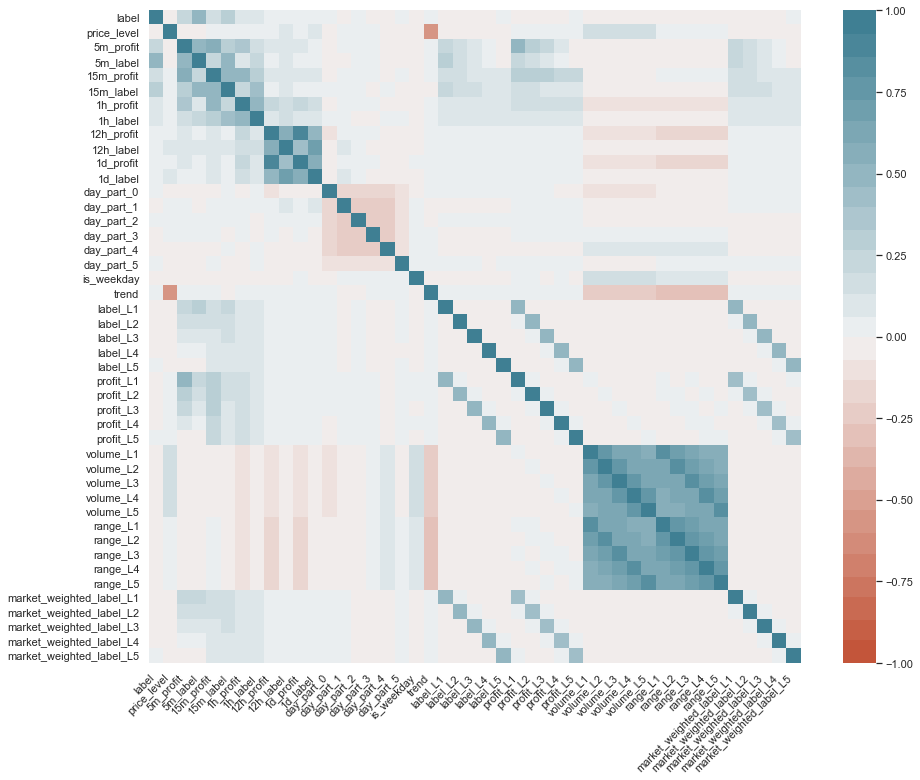

In [38]:
corr = features_dic["BTCUSDT"].corr()
plt.figure(figsize=(15,12))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=30),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## 4.2. Build Modelling Class:

In [39]:
class modelling():
    def __init__(self, data):
        self.data = data
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_split()
    
    def train_test_split(self, test_ratio = 0.2):
        train_size = len(self.data)*(1-test_ratio)
        train_size = round(train_size)
        
        train_data = self.data.iloc[:train_size , :]
        test_data  = self.data.iloc[train_size: , :]
        X_train = train_data.drop("label", 1)
        X_test  = test_data.drop("label", 1)
        y_train = train_data["label"]
        y_test  = test_data["label"] 
    
        return X_train, X_test, y_train, y_test
    

    def fit_xgb_model(self):
        param_grid_xgb = {
                  'n_estimators' :[100,200, 500],
                  #"learning_rate" : [0.001, 0.01, 0.10],
                  #"gamma"            : [ 0.0, 0.2 ],
                  #'max_depth': [4,6,8]
              }
        
        xgb_model = GridSearchCV(XGBClassifier(n_jobs=-1), param_grid=param_grid_xgb, cv=5, refit=True)
        xgb_model.fit(self.X_train, self.y_train)
        return xgb_model
        
    def fit_logistic_regression(self):
        logit_model = LogisticRegression(random_state = 56)
        logit_model.fit(self.X_train, self.y_train)
        return logit_model

    def fit_random_forest(self):
        
        param_grid_rf = {'max_depth': [4, 6, 8],
                        # 'min_samples_leaf': [4,7, 10],
                         'n_estimators': [100, 200, 1000]}
        
        rf_model = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=param_grid_rf, cv=5, refit=True)
        rf_model.fit(self.X_train, self.y_train)
        return rf_model
        
    def get_test_data_predictions(self, model):
        y_pred = model.predict(X_test)
        return y_pred
        
    
    def plot_cm(self, y_true, y_pred, title_name , figsize=(4,4)):
        
        '''
        This method draws a confusion matrix for predicitons 
        '''
        
        cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum.astype(float) * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%.1f%%\n%d' % (p, c)
        cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
        cm.index.name = 'Actual'
        cm.columns.name = 'Predicted'
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax).set_title(title_name, fontsize=20)
    
    
my_modelling_class = modelling(features_dic["BTCUSDT"])


## 4.3. Fitting the Models:

In [40]:
xgb_model = my_modelling_class.fit_xgb_model()
logit_model = my_modelling_class.fit_logistic_regression()
rf_model = my_modelling_class.fit_random_forest()

## 4.4. Performance Checks:

Accuracy: 0.7680567641743089


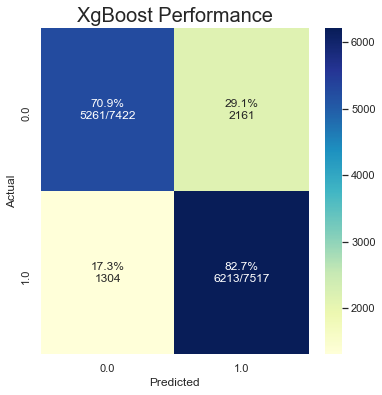

In [41]:
X_train, X_test, y_train, y_test = my_modelling_class.train_test_split()

# XGB 
y_pred = xgb_model.predict_proba(X_test)
y_pred = (np.array(y_pred)[:,1] > 0.5)*1

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
my_modelling_class.plot_cm(y_test, y_pred, "XgBoost Performance", figsize=(6, 6))


Accuracy: 0.7463016266149006


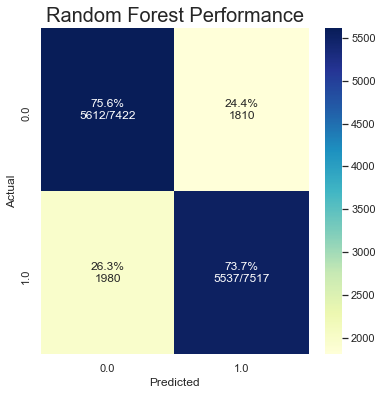

In [42]:
# RF 
y_pred = rf_model.predict_proba(X_test)
y_pred = (np.array(y_pred)[:,1] > 0.5)*1

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
my_modelling_class.plot_cm(y_test, y_pred, "Random Forest Performance", figsize=(6, 6))


Accuracy: 0.5035142914519044


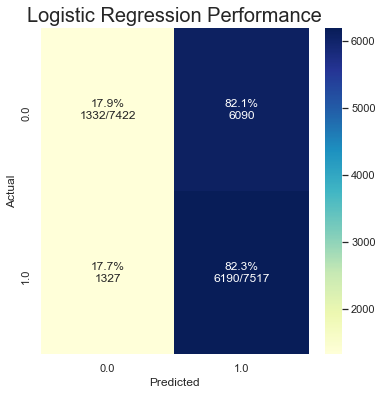

In [43]:
# Logit
y_pred = logit_model.predict_proba(X_test)
y_pred = (np.array(y_pred)[:,1] > 0.5)*1

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
my_modelling_class.plot_cm(y_test, y_pred, "Logistic Regression Performance", figsize=(6, 6))


## Fitting Models for Other Coins:

In [44]:
xgb_model.best_params_

{'n_estimators': 100}

The best model is XGBoost with 'n_estimators': 100 for Bitcoin. I will build a model with those parameters for all coins.

In [45]:
models_dict = {}
performances_dict = {}

xgb_clf = XGBClassifier(n_jobs=-1, n_estimators = 100)


for symbol in features_dic.keys():
    temp_modelling_class = modelling(features_dic[symbol])
    X_train, X_test, y_train, y_test = temp_modelling_class.X_train, temp_modelling_class.X_test, temp_modelling_class.y_train, temp_modelling_class.y_test
    temp_model = xgb_clf.fit(X_train, y_train)
    models_dict[symbol] = temp_model
    performances_dict[symbol] = np.round(accuracy_score(y_test, temp_model.predict(X_test)), 2)


    


In [46]:
performances_dict

{'BTCUSDT': 0.77,
 'ETHUSDT': 0.77,
 'BNBUSDT': 0.74,
 'DOGEUSDT': 0.78,
 'ADAUSDT': 0.76,
 'MATICUSDT': 0.76,
 'DOTUSDT': 0.64,
 'TRXUSDT': 0.77,
 'LTCUSDT': 0.77,
 'SOLUSDT': 0.72,
 'UNIUSDT': 0.69,
 'AVAXUSDT': 0.77,
 'LINKUSDT': 0.76,
 'XMRUSDT': 0.81,
 'ATOMUSDT': 0.76,
 'ETCUSDT': 0.78,
 'XLMUSDT': 0.83,
 'ALGOUSDT': 0.78,
 'VETUSDT': 0.81,
 'NEARUSDT': 0.77,
 'HBARUSDT': 0.88}

# 5. Profit expectations:

In [47]:
# Strategy: Buy if predicted probability > 70% 

In [48]:
temp_modelling_class = modelling(features_dic["BTCUSDT"])
X_train, X_test, y_train, y_test = temp_modelling_class.X_train, temp_modelling_class.X_test, temp_modelling_class.y_train, temp_modelling_class.y_test
temp_model = xgb_clf.fit(X_train, y_train)
y_pred = models_dict["BTCUSDT"].predict(X_test)

test_pred = pd.DataFrame({"y_test" : y_test,  "y_pred" : y_pred, "predicted_probs" : models_dict["BTCUSDT"].predict_proba(X_test)[:,1]}, index=y_test.index)

data = klines_data_dict["BTCUSDT"].astype(float)

data["profit"] = (data.close - data.open)/data.open
data = data.merge(test_pred, "inner", right_index=True, left_index=True)
data["is_correct"] = data.y_test == data.y_pred
data["is_a_buy"] = data.predicted_probs > 0.7
data

,timestamp,open,high,low,close,volume,label,profit,y_test,y_pred,predicted_probs,is_correct,is_a_buy
timestamp,,,,,,,,,,,,,
2022-12-12 15:02:00,1.670847e+12,16987.72,16988.31,16985.22,16986.15,133.00590,0.0,-0.000092,0.0,0,0.043999,True,False
2022-12-12 15:03:00,1.670847e+12,16985.74,16987.50,16984.31,16985.49,118.57841,0.0,-0.000015,0.0,0,0.161157,True,False
2022-12-12 15:04:00,1.670847e+12,16985.49,16988.08,16985.12,16985.80,98.38224,1.0,0.000018,1.0,0,0.113769,False,False
2022-12-12 15:05:00,1.670847e+12,16985.35,16987.15,16981.82,16984.05,157.25241,0.0,-0.000077,0.0,0,0.096540,True,False
2022-12-12 15:06:00,1.670847e+12,16984.56,16984.70,16980.45,16981.74,128.18061,0.0,-0.000166,0.0,0,0.119954,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22 23:56:00,1.671743e+12,16778.61,16786.87,16772.03,16785.43,160.45849,1.0,0.000406,1.0,1,0.978020,True,True
2022-12-22 23:57:00,1.671743e+12,16785.43,16788.99,16781.80,16784.69,95.95904,0.0,-0.000044,0.0,1,0.703152,False,True
2022-12-22 23:58:00,1.671743e+12,16784.69,16789.42,16781.31,16782.91,151.90584,0.0,-0.000106,0.0,1,0.791380,False,True


<AxesSubplot:xlabel='timestamp', ylabel='profit'>

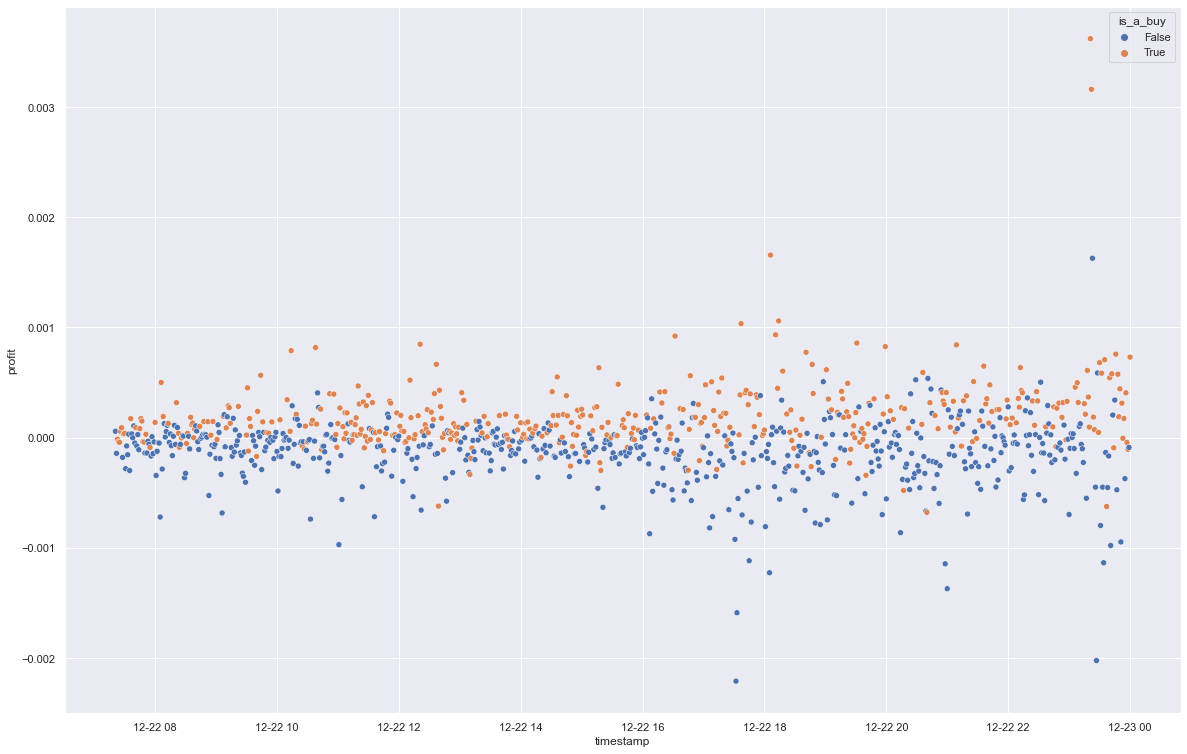

In [49]:
sns.set(rc={'figure.figsize':(20,13)})
sns.scatterplot(y=data.profit[-1000:], x=data.index[-1000:], hue = data.is_a_buy[-1000:])



In [50]:
buys = data.loc[data.is_a_buy==1, "profit"]

In [51]:
trading_fee_rate = 0.00020
print(f"The expected profit rate in during the test set is: {np.prod(buys+1-trading_fee_rate)} the duration takes {X_test.index[-1] - X_test.index[0]}.")


The expected profit rate in during the test set is: 1.248940736848709 the duration takes 10 days 08:58:00.
